In [40]:
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.preprocessing import normalize
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
####### Change this to the second line if you are running locally #######
data = "drive/My Drive/PROJ S/Train_Test_data/"
#data = "../../Data/"

Mounted at /content/drive


# Moon Position

### Moon data, PCA

We are able to use X, Y, Z coordinates as Ptolemy had a pretty good estimate of the distance from the Earth to the Moon 

In [41]:
# connect drive
moon_data = pd.read_csv(data + "Moon2x.csv")
moon_data.head()

,Unnamed: 0,Time,Right Ascension,Declination,Distance,X,Y,Z
0,0,2019-11-02 00:00:00.000000000,282.159899,-23.839308,384757.021309,74130.881791,-344034.483716,-155508.365773
1,1,2019-11-02 00:08:13.761310601,282.209434,-23.837778,384815.329210,74440.443967,-344026.450869,-155522.535344
2,2,2019-11-02 00:16:27.522621202,282.259143,-23.835818,384879.579637,74752.500679,-344024.368148,-155536.454196
3,3,2019-11-02 00:24:41.283931803,282.309065,-23.833429,384949.733058,75067.284738,-344028.136987,-155550.122805
4,4,2019-11-02 00:32:55.045242404,282.359237,-23.830615,385025.742595,75385.025251,-344037.650472,-155563.541637


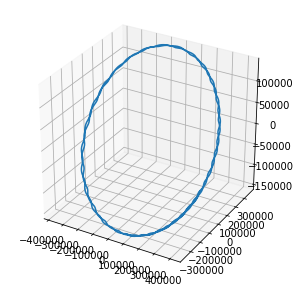

(10500, 8)

In [42]:
xyz = moon_data[['X', 'Y', 'Z']].to_numpy()
xyz[:5]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2])
plt.show()
moon_data.shape

In [43]:
pca = PCA(n_components=2)
pca.fit(xyz)
lower_dim_xy = pca.transform(xyz)
lower_dim_xyt = np.array([np.append(lower_dim_xy[i], i) for i in range(lower_dim_xy.shape[0])])

[[-0.71994811  0.6127415   0.32591806]
 [-0.68823159 -0.69088278 -0.22140068]]
2.914335439641036e-16
[[-2.62441613e+05  2.35186726e+05  0.00000000e+00]
 [-2.62664177e+05  2.34971263e+05  1.00000000e+00]
 [-2.62892102e+05  2.34758138e+05  2.00000000e+00]
 [-2.63125495e+05  2.34547124e+05  3.00000000e+00]
 [-2.63364454e+05  2.34337989e+05  4.00000000e+00]]


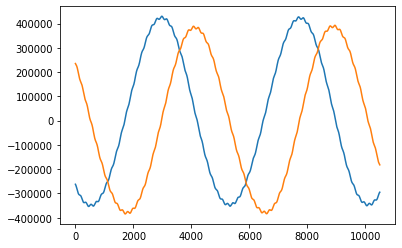

In [44]:
# These are approximately perpendicular unit vectors 
# (since our data shows that the path is approximately an ellipse)
print(pca.components_)
print(np.dot(pca.components_[0], pca.components_[1]))
print(lower_dim_xyt[:5])
plt.plot(lower_dim_xy)

Find major and minor axis of ellipse through regression 

In [45]:
def linear_regress_ellipse(two_dim_inp):
  ones = np.ones((two_dim_inp.shape[0], 1))
  phi = two_dim_inp ** 2
  print(two_dim_inp.shape)
  print(ones.shape)
  coef = np.linalg.inv(phi.T @ phi) @ phi.T @ ones
  return coef

In [46]:
coef = linear_regress_ellipse(lower_dim_xyt)
a = np.sqrt(1/coef[0])
b = np.sqrt(1/coef[1])
print(a, b)


(10500, 3)
(10500, 1)
[397456.12867084] [389164.20762901]


### Phase exploration

Fit theta to timestep as sin function with major ellipse axis as amplitude. Insert ptolemy justification here to have constant angular velocity instead of Kepler's angular velocity law which came after



In [47]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_amp = np.std(yy) * 2.**0.5
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

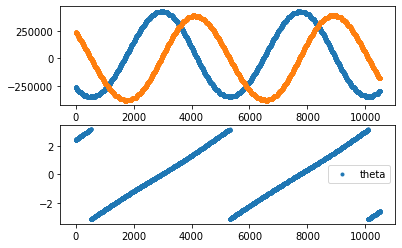

In [48]:
# Plot 2d data with time step as sin wave
x_ = lower_dim_xyt[:,0]
y_ = lower_dim_xyt[:,1]
t_ = lower_dim_xyt[:,2]

theta = np.arctan2(y_,x_)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_, x_, '.',label='x')
ax1.plot(t_, y_, '.', label='y')
ax2.plot(t_, theta, '.', label='theta')
plt.legend()
plt.show()

In [49]:
x_ = lower_dim_xyt[:,0]
y_ = lower_dim_xyt[:,1]
t_ = lower_dim_xyt[:,2]

theta = np.arctan2(y_,x_)
eps = 1e-3
neg_eps = -1 * eps
zero_idx = np.argwhere((theta < eps) & (theta > neg_eps))
zero_idx

array([[2969],
       [7721]])

In [50]:
theta[0]

2.4109093869530627

theta = 

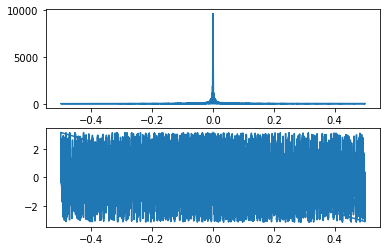

In [51]:
dft = np.fft.fft(theta)
freq = np.fft.fftfreq(len(theta), t_[1] - t_[0])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(freq, np.abs(dft))
ax2.plot(freq, np.angle(dft))
plt.show()

In [ ]:
idx = np.argmax(abs(dft))
print(idx)
peak_f = abs(freq[idx])
print(peak_f)
peak_period = 1/peak_f
print(peak_period)
n = theta.shape[0]

ps = abs(dft[0:int(n/2)])**2/n
sorted_fourier = np.sort(ps.flatten())[::-1]
top_fourier = sorted_fourier[:15]
print(top_fourier)
freqs = [list(ps).index(i) for i in list(top_fourier)]
fourier = dft[freqs]
print(freqs)

for f in freqs:
  peak_f = abs(freq[f])
  print(peak_f)
  peak_period = 1/peak_f
  print(peak_period)
  n = theta.shape[0]



In [53]:
x_period = fit_sin(t_, x_)['period']
y_period = fit_sin(t_, y_)['period']
avg_period_theta = (x_period + y_period) / 2
print(f'Average period in timesteps: {avg_period_theta}')
# Now our functions for x' and y' are acos(t/avg_period + c) and bsin(t/avg_period + c)

Average period in timesteps: 4803.613651077767


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [54]:
try:
  t0 = datetime.strptime(moon_data['Time'][0],'%Y-%m-%d %H:%M:%S.%f')
except ValueError:
  print(moon_data['Time'][0].split('.')[0])
  t0 = datetime.strptime(moon_data['Time'][0].split('.')[0],'%Y-%m-%d %H:%M:%S')

t1 = datetime.strptime(moon_data['Time'][1][:-3],'%Y-%m-%d %H:%M:%S.%f')
print(f't0: {t0}')
timestep = t1 - t0
print(timestep)
print(timestep.total_seconds())
avg_period_seconds = avg_period_theta * timestep.total_seconds()
print(f'Average period in seconds: {avg_period_seconds}')

standard_step = zero_idx[0][0]
print(type(standard_step))
new_timestep = (standard_step * timestep)
print(type(new_timestep))
standard_time = t0 + (standard_step * timestep)
print(type(t0))
print(type(timestep))
print(standard_time)
print(type(standard_time))

2019-11-02 00:00:00
t0: 2019-11-02 00:00:00
0:08:13.761310
493.76131
Average period in seconds: 2371838.569090041
<class 'numpy.int64'>
<class 'datetime.timedelta'>
<class 'datetime.datetime'>
<class 'datetime.timedelta'>
2019-11-18 23:12:57.329390
<class 'datetime.datetime'>


# Lunar Phases

Moon phases are determined by the angle between the moon and the sun relative to the Earth. We can work with these angles since we have positional data between the moon and sun relative to the Earth already. 

Can do this two ways: create explicit predictive models for the moon and sun's positions, and then predict phase from the predicted positions. Otherwise, simply pump in a time and let some model ignore all the details.

Although mathematically the first case would likely be more mathematically significant, it also may be unnecessary since have a good estimate of the lunar cycle already.

#### Getting Data

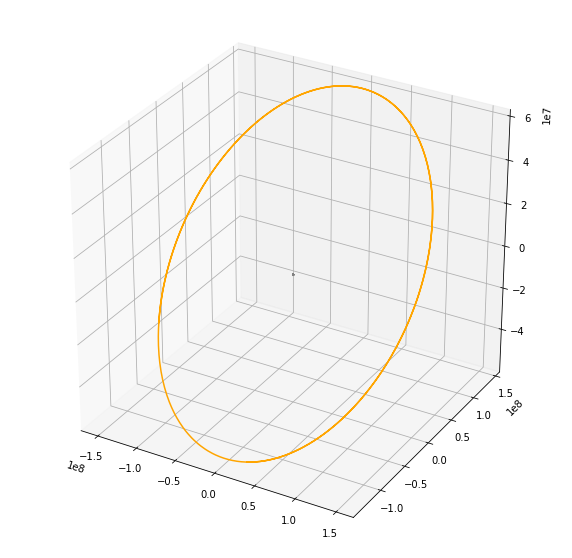

In [55]:
moon = pd.read_csv(data + "Moon_phase2.csv")
sun = pd.read_csv(data + "Sun_phase2.csv")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sun['X'], sun['Y'], sun['Z'], color='orange')
ax.plot(moon['X'], moon['Y'], moon['Z'], color='grey')
plt.show()

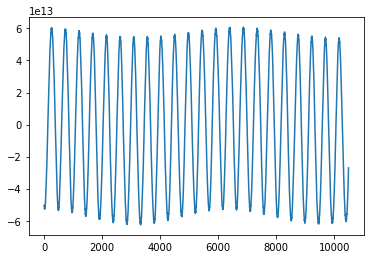

In [56]:
moon_xyz = moon[['X', 'Y', 'Z']]
sun_xyz = sun[['X', 'Y', 'Z']]
angles = (sun_xyz * moon_xyz).sum(axis=1)

plt.plot(angles)

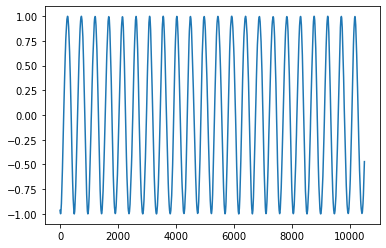

In [57]:
moon_xyz = normalize(moon[['X', 'Y', 'Z']], norm='l2')
sun_xyz = normalize(sun[['X', 'Y', 'Z']], norm='l2')
normalized_angles = (sun_xyz * moon_xyz).sum(axis=1)

plt.plot(normalized_angles)

This shows a pretty clear period of the moon phases. The trophs are full moons and the peaks are new moons. The rising 0's are the final quarter and the falling 0's are the first quarter. 
While initially it seems as though the lunar cycle may shift over each cycle, the changes in peaks and trophs are simply because of slightly changing distances to the Sun over an Earth year. Normalizing the data to unit vectors for the direction of the Moon and direction over the Sun, *and then* taking the dot product for angle, shows almost a perfect sinusoid. We can extrapolate well from this format.

In [58]:
pred_sine = fit_sin(sun.index, angles)
norm_pred_sine = fit_sin(sun.index, normalized_angles)
norm_pred_sine

{'amp': 0.9893681766682741,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>>,
 'freq': 0.002116778408989461,
 'maxcov': 3.3959847146527244e-06,
 'offset': -0.004983476355927942,
 'omega': 0.013300110997917561,
 'period': 472.4160052621638,
 'phase': -1.8276447908715865,
 'rawres': (array([ 0.99583289,  0.01316477,  0.        , -0.0133171 ]),
  array([ 0.98936818,  0.01330011, -1.82764479, -0.00498348]),
  array([[ 8.18940651e-07, -2.25249146e-13,  5.71509857e-09,
           6.86866748e-09],
         [-2.25249146e-13,  9.27393718e-14, -4.86486852e-10,
           4.65398178e-12],
         [ 5.71509857e-09, -4.86486852e-10,  3.39598471e-06,
          -2.77474159e-08],
         [ 6.86866748e-09,  4.65398178e-12, -2.77474159e-08,
           4.11520224e-07]]))}

#### Fitting non-normalized phase data
Using Kernel Ridge Regression with the ExpSineSquared kernel, which is a periodic kernel (allowing us to fit this periodic function). We used the fft function from earlier to get an estimate of the period.

In [59]:
param_grid = {"alpha": [1e-1, 1e-2],
              "kernel": [ExpSineSquared(l, p)
                         for l in [100]
                         for p in [pred_sine['period']]]}
kr = GridSearchCV(KernelRidge(), param_grid=param_grid)
kr.fit(sun.index.to_numpy().reshape(-1, 1), angles)


GridSearchCV(cv=None, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.01],
                         'kernel': [ExpSineSquared(length_scale=100, periodicity=472)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Text(0.5, 1.0, 'Squared Errors')

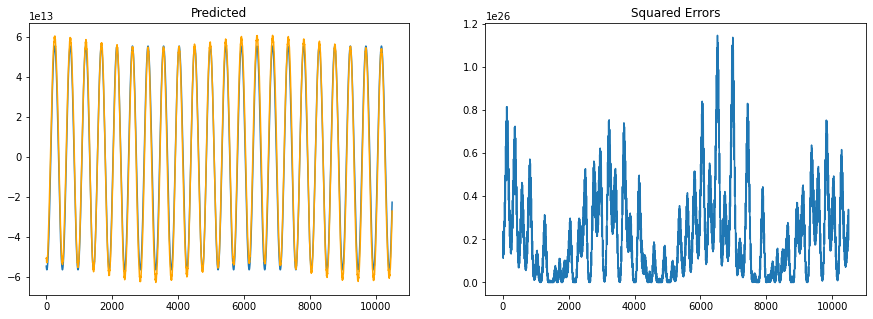

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
X_plot = np.linspace(0, 10500, 10500)[:, None]
y_kr = kr.predict(X_plot)
ax1.plot(X_plot, y_kr)
ax1.plot(X_plot, angles, color='orange')
ax1.set_title('Predicted')

phase_error = (y_kr - angles) ** 2
ax2.plot(phase_error)
ax2.set_title('Squared Errors')

#### Fitting normalized phase data
1: Regular sine with parameters from fft

2: Kernel Ridge with ExpSineSquared kernel


In [61]:
param_grid = {"alpha": [1e-1, 1e-2],
              "kernel": [ExpSineSquared(l, p)
                         for l in [100]
                         for p in [pred_sine['period']]]}
kr2 = GridSearchCV(KernelRidge(), param_grid=param_grid)
kr2.fit(sun.index.to_numpy().reshape(-1, 1), normalized_angles)


GridSearchCV(cv=None, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.01],
                         'kernel': [ExpSineSquared(length_scale=100, periodicity=472)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Text(0.5, 1.0, 'Squared Errors')

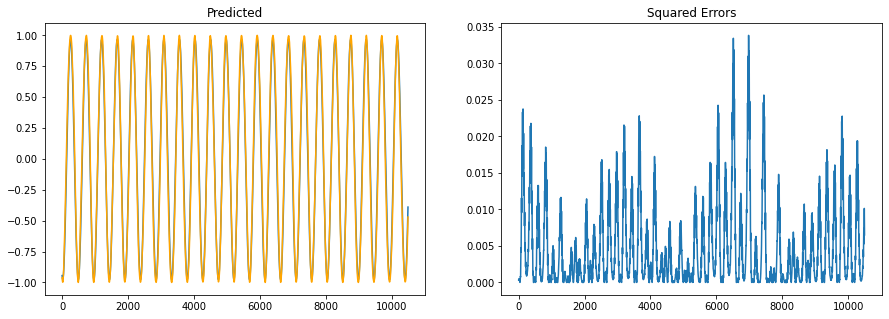

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
X_plot = np.linspace(0, 10500, 10500)[:, None]
y_kr2 = kr2.predict(X_plot)
ax1.plot(X_plot, y_kr2)
ax1.plot(X_plot, normalized_angles, color='orange')
ax1.set_title('Predicted')

phase_error2 = (y_kr2 - normalized_angles) ** 2
ax2.plot(phase_error2)
ax2.set_title('Squared Errors')

Text(0.5, 1.0, 'Squared Errors')

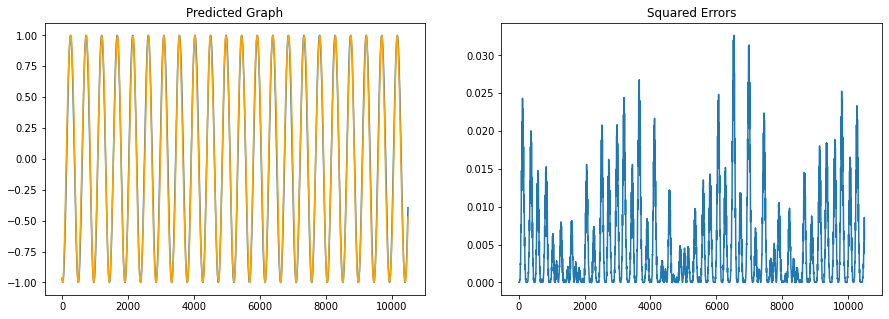

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
X_plot = np.linspace(0, 10500, 10500)[:, None]
period = norm_pred_sine['period']
phase = norm_pred_sine['phase']
y_sine = np.sin(X_plot * 2 * np.pi / period + phase)
ax1.plot(X_plot, y_sine)
ax1.plot(X_plot, normalized_angles, color='orange')
ax1.set_title('Predicted Graph')

phase_error3 = (y_sine.reshape(-1, 10500) - normalized_angles) ** 2
phase_error3 = phase_error3.reshape(phase_error2.shape)
ax2.plot(phase_error3)
ax2.set_title('Squared Errors')

While the errors between normalized and non-normalized data are similar, normalizing allows us to set thresholds for the different lunar phases, without having to consider which part of the year it is. This is more logically consistent with the fact that the moon's phase does not change if the angle is held constant but the distance from the sun is changed. The Kernel Ridge Regression model just as robust as simply fitting a sine function with the parameters from FFT, showing just how sinusoidal the lunar cycle is. We will therefore predict with either one.

# Moon Predictors

### Position

In [76]:
def linear_regress_ellipse(two_dim_inp):
  ones = np.ones((two_dim_inp.shape[0], 1))
  phi = two_dim_inp ** 2
  #print(two_dim_inp.shape)
  #print(ones.shape)
  coef = np.linalg.inv(phi.T @ phi) @ phi.T @ ones
  return coef

#Source: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_amp = np.std(yy) * 2.**0.5
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

class BlueCheeseWherePredictor:
  def __init__(self):
    self.sample_time = "2019-11-02 00:00:00"
    self.timestep = None
    self.standard_time = None
    self.cycle_period = 0
    self.cycle_period_s = 0
    self.a = 0
    self.b = 0
    self.major_axis = None
    self.minor_axis = None
    
  def fit(self, moon_data):
    #updates timestep, standard_time, cycle_period
    #Get major and minor axes
    pca = PCA(n_components=2)
    pca.fit(xyz)
    lower_dim_xy = pca.transform(xyz)
    self.major_axis = pca.components_[0]
    self.minor_axis = pca.components_[1]
    lower_dim_xyt = np.array([np.append(lower_dim_xy[i], i) for i in range(lower_dim_xy.shape[0])])
    
    #Get a and b
    coef = linear_regress_ellipse(lower_dim_xyt)
    self.a = np.sqrt(1/coef[0])
    self.b = np.sqrt(1/coef[1])

    #Get standard cycle values
    x_ = lower_dim_xyt[:,0]
    y_ = lower_dim_xyt[:,1]
    t_ = lower_dim_xyt[:,2]

    theta = np.arctan2(y_,x_)
    eps = 1e-3
    neg_eps = -1 * eps
    zero_idx = np.argwhere((theta < eps) & (theta > neg_eps))
    x_period = fit_sin(t_, x_)['period']
    y_period = fit_sin(t_, y_)['period']
    self.cycle_period = (x_period + y_period) / 2

    t0 = datetime.strptime(moon_data['Time'][0].split('.')[0],'%Y-%m-%d %H:%M:%S')
    t1 = datetime.strptime(moon_data['Time'][1].split('.')[0],'%Y-%m-%d %H:%M:%S')
    print(f't0: {t0}')
    self.timestep = t1 - t0
    print(f'timestep seconds: {self.timestep.total_seconds()}')
    self.cycle_period_s = self.cycle_period * self.timestep.total_seconds()
    print(f'Average period in seconds: {self.cycle_period_s}')

    standard_step = zero_idx[0][0]
    self.standard_time = t0 + standard_step * self.timestep
    pass

  def predict(self, time):
    try: 
      pred_time = datetime.strptime(time,'%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
      pred_time = datetime.strptime(time.split('.')[0], '%Y-%m-%d %H:%M:%S')
    time_delta = (pred_time - self.standard_time)
    #print(f'td: {time_delta.total_seconds()}')
    time_delta = time_delta.total_seconds() % self.cycle_period_s
    #print(f'td: {time_delta}')
    theta = (time_delta / self.cycle_period_s) * (2 * np.pi)
    #print(f'theta: {theta}')
    xp = a * np.cos(theta)
    yp = b * np.sin(theta)
    xyz = xp * self.major_axis + yp * self.minor_axis
    
    return xyz
  
  def predict_array(self, times):
    xyzs = np.zeros(shape=(times.shape[0], 3))
    for i, time in enumerate(times):
      xyzs[i] = self.predict(time)
    return xyzs

In [77]:
sim = BlueCheeseWherePredictor()
moon_data = pd.read_csv(data + "Moon2x.csv")
sim.fit(moon_data)

t0: 2019-11-02 00:00:00
timestep seconds: 493.0
Average period in seconds: 2368181.529565075


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


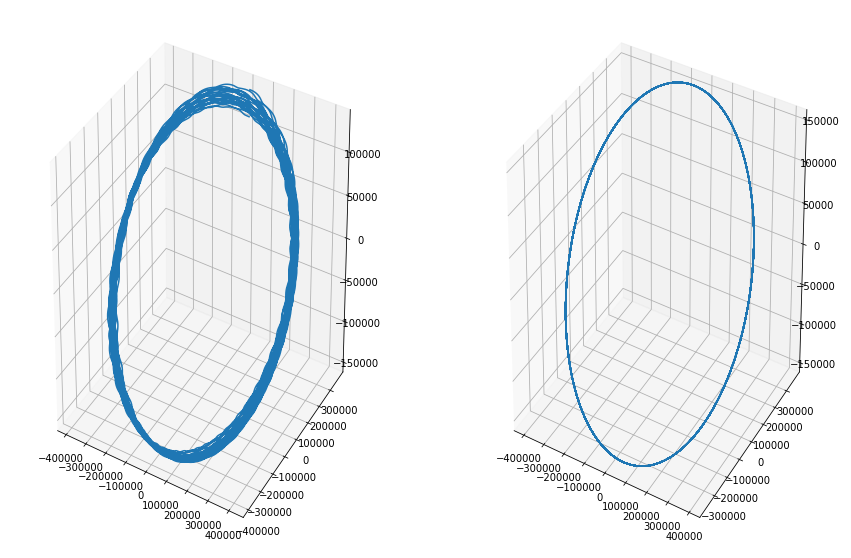

In [79]:
#Testing
test_moon_pos = pd.read_csv(data + "Moon_phase2.csv")
pred_xyzs = sim.predict_array(test_moon_pos['Time'])
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(test_moon_pos['X'], test_moon_pos['Y'], test_moon_pos['Z'])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(pred_xyzs[:, 0], pred_xyzs[:, 1], pred_xyzs[:, 2])
plt.show()

(10500,)
RMSE: 494139.9144908959


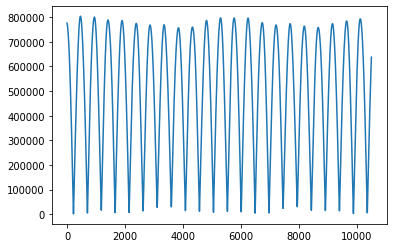

In [80]:
errors = np.linalg.norm(xyz - pred_xyzs, axis=1)
print(errors.shape)
plt.plot(errors)
print(f'RMSE: {np.mean(errors)}')

These errors don't look great. Although the general shape look good, since we extrapolated from the primary plane of the moon's orbit, the moon's orbit isn't perfectly repeated. Although not sure what the underlying mechanism for this is, this is likely related to the different periods of x' and y' we found earlier. Future iterations, we can predict x' and y' separately and therefore can attribute for this difference in periodicity.

### Phase

In [81]:
#Source: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_amp = np.std(yy) * 2.**0.5
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}
class BlueCheeseAmountPredictor:
  def __init__(self):
    self.sample_time = "2019-11-02 00:00:00"
    self.timestep = None
    self.standard_time = None
    self.period = 0
    self.phase = 0

  def fit(self, input_moon, input_sun):
    # For now it assumes the moon data and sun data are perfectly aligned in time
    t0 = datetime.strptime(input_moon['Time'][0].split('.')[0],'%Y-%m-%d %H:%M:%S')
    t1 = datetime.strptime(input_moon['Time'][1].split('.')[0],'%Y-%m-%d %H:%M:%S')
    self.standard_time = t0
    self.timestep = t1 - t0
    print(f'moon t0: {t0}')
    print(f'moon timestep: {self.timestep}')

    moon_xyz = normalize(input_moon[['X', 'Y', 'Z']], norm='l2')
    sun_xyz = normalize(input_sun[['X', 'Y', 'Z']], norm='l2')
    normalized_angles = (sun_xyz * moon_xyz).sum(axis=1)
    norm_pred_sine = fit_sin(input_sun.index, normalized_angles)
    self.period = norm_pred_sine['period']
    self.phase = norm_pred_sine['phase']

  def predict(self, time):
    try: 
      pred_time = datetime.strptime(time,'%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
      pred_time = datetime.strptime(time.split('.')[0], '%Y-%m-%d %H:%M:%S')
    time_delta = pred_time - self.standard_time
    time_delta = time_delta.total_seconds() / self.timestep.total_seconds()
    time_delta = time_delta % self.period
    prev_time_delta = time_delta - (.1 / self.period)
    phase_angle = -1 * np.sin(time_delta * 2 * np.pi / self.period + self.phase)
    prev_angle = -1 * np.sin(prev_time_delta * 2 * np.pi / self.period + self.phase)
    #print(f'phase_angle: {phase_angle}')
    #print(f'prev_angle: {prev_angle}')
    new_full_eps = 5e-3
    quarter_eps = 2e-1
    if abs(phase_angle + 1) <= new_full_eps:
      return phase_angle, "Full Moon"
    elif abs(phase_angle - 1) <= new_full_eps:
      return phase_angle, "New Moon"
    else:
      #Going from Full to New
      if phase_angle > prev_angle:
        if abs(phase_angle) <= quarter_eps:
          return phase_angle, "Third Quarter"
        elif phase_angle > 0: 
          return phase_angle, "Waning Crescent"
        else:
          return phase_angle, "Waning Gibbous"
      #Going from New to Full
      else:
        if abs(phase_angle) <= quarter_eps:
          return phase_angle, "First Quarter"
        elif phase_angle > 0: 
          return phase_angle, "Waxing Crescent"
        else:
          return phase_angle, "Waxing Gibbous"

In [82]:
sim2 = BlueCheeseAmountPredictor()
#Fit it on 80% of the data, test on the other 20%
moon = pd.read_csv(data + "Moon_phase2.csv")
sun = pd.read_csv(data + "Sun_phase2.csv")
train_size = (int) (moon.shape[0] * .8)
print(moon[:train_size].shape)
print(sun[:train_size].shape)
sim2.fit(moon[:train_size], sun[:train_size])

(8400, 8)
(8400, 8)
moon t0: 2018-01-01 00:00:00
moon timestep: 1:30:00


In [83]:
phase_angle, phase_str = sim2.predict("1964-01-07 00:00:00")
print(phase_angle)
print(phase_str)

0.41985399256275885
Waning Crescent


In [84]:
moon_xyz = normalize(moon[['X', 'Y', 'Z']][train_size:], norm='l2')
sun_xyz = normalize(sun[['X', 'Y', 'Z']][train_size:], norm='l2')
real_normalized_angles = (sun_xyz * moon_xyz).sum(axis=1)
pred_phases = []
for time in moon.Time[train_size:]:
  phase_angle, phase_str = sim2.predict(time)
  pred_phases.append(phase_angle)
pred_phases = np.array(pred_phases)

Text(0.5, 1.0, 'true')

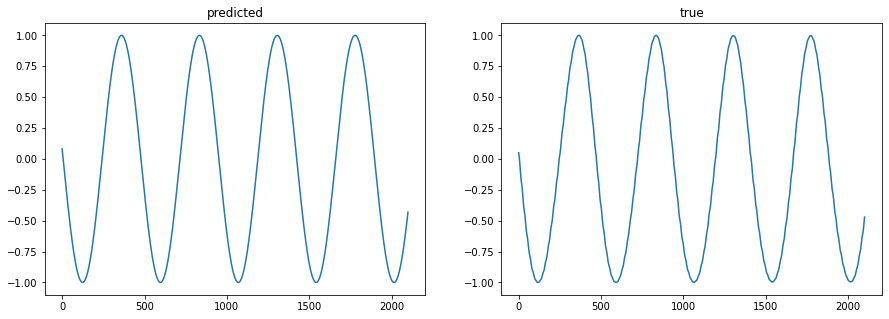

In [85]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(pred_phases)
ax1.set_title('predicted')
ax2.plot(real_normalized_angles)
ax2.set_title('true')

(2100,)
RMSE: 0.005628066905837782


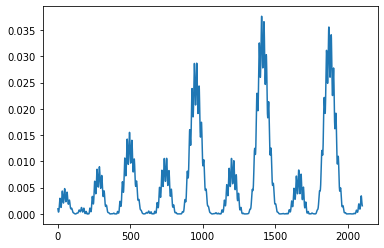

In [86]:
errors = (pred_phases - real_normalized_angles) ** 2
print(errors.shape)
plt.plot(errors)
print(f'RMSE: {np.mean(errors)}')

These errors look pretty good locally. RMSE of 0.00563 is quite low, although our data only ranges from -1 to 1. It looks pretty good, and individually testing it on ranges of years (for example January 1-5, 1964), shows that the angle is close enough that it will still predict near the correct phase of the moon. 